# Build a CNN audio classifier using melspectograms from Audioset and ESC-50 data

## Load required modules

In [1]:
%matplotlib inline
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input
import numpy as np
import json
import os
import shutil
import random
import itertools
import matplotlib.pyplot as plt
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print device_lib.list_local_devices()

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16572324929097342438
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 56033280
locality {
  bus_id: 1
}
incarnation: 17993344051382349124
physical_device_desc: "device: 0, name: Quadro P5000, pci bus id: 0000:00:05.0"
]


## Utility functions

In [3]:
def split_dataset(file_paths, label_dir, train_split):
    # get new train and validation indices
    n_files = len(file_paths)
    n_train = int(train_split * n_files)
    train_idx = random.sample(range(n_files), n_train)
    val_idx = list(set(range(n_files)) - set(train_idx))
    
    # split files
    train_set = [file_paths[idx] for idx in train_idx]
    val_set = [file_paths[idx] for idx in val_idx]

    return train_set, val_set

In [4]:
# create and save train and validation splits into tmp directories
def train_and_val_split(path_to_train_set, train_split, seed=23):
    random.seed(seed)

    train_labels = os.listdir(path_to_train_set)
    print '{} classes observed'.format(len(train_labels))
    
    # split original files
    train_dir = '/tmp/train'
    val_dir = '/tmp/val'
    n_train_files = 0
    n_val_files = 0
    for label_dir in train_labels:
        # fill in dictionary
        full_path_to_dir = os.path.join(path_to_train_set, label_dir)
        files = os.listdir(full_path_to_dir) 
        file_paths = [os.path.join(path_to_train_set, label_dir, f) for f in files]
        train_set, val_set = split_dataset(file_paths, label_dir, train_split)
        
        # copy files over to tmp directories
        train_label_dir = os.path.join(train_dir, label_dir)
        if os.path.exists(train_label_dir):
            shutil.rmtree(train_label_dir)
        os.makedirs(train_label_dir)
            
        val_label_dir = os.path.join(val_dir, label_dir)
        if os.path.exists(val_label_dir):
            shutil.rmtree(val_label_dir)
        os.makedirs(val_label_dir)
        
        def tmp_train_path(f):
            base_filename = os.path.basename(f)
            return os.path.join(train_label_dir, base_filename)
        def tmp_val_path(f):
            base_filename = os.path.basename(f)
            return os.path.join(val_label_dir, base_filename)
        
        map(lambda f: shutil.copyfile(f, tmp_train_path(f)), train_set)
        map(lambda f: shutil.copyfile(f, tmp_val_path(f)), val_set)
        
        n_train_files += len(train_set)
        n_val_files += len(val_set)
                 
    print 'Found {} files for train set'.format(n_train_files)
    print 'Found {} files for validaiton set'.format(n_val_files)
                 
    return train_dir, val_dir

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Set parameter values

In [6]:
data_source = 'continuous_wavelet_transform'
batch_size = 40
epochs = 150

# dimensions of our images.
img_width, img_height = 224, 224

input_tensor = Input(shape=(224,224,3))

# Configure training and validation data generators

In [7]:
training_data_dir = '../hackathon_dataset/{}/train'.format(data_source)

In [8]:
# training generator configuration
training_datagen = image.ImageDataGenerator(
    rescale=1./255)

training_generator = training_datagen.flow_from_directory(
    training_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size)

Found 3716 images belonging to 2 classes.


In [9]:
validation_data_dir = '../hackathon_dataset/{}/validation'.format(data_source)

In [10]:
# validation generator configuration
validation_datagen = image.ImageDataGenerator(
    rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size)

Found 1219 images belonging to 2 classes.


In [11]:
nb_training_samples = 3716
nb_validation_samples = 1219
n_classes = len(os.listdir(training_data_dir)) - 1
class_labels = os.listdir(training_data_dir)[:-1]

# Load base model

In [13]:
model_name = 'vgg16'
pretrained_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)
print('Model loaded')
print pretrained_model.summary()

ResourceExhaustedError: OOM when allocating tensor with shape[3,3,512,512]
	 [[Node: block4_conv3_1/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=8090260, _device="/job:localhost/replica:0/task:0/gpu:0"](block4_conv3_1/random_uniform/shape)]]

Caused by op u'block4_conv3_1/random_uniform/RandomUniform', defined at:
  File "/usr/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2822, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-428d6a3d251c>", line 2, in <module>
    pretrained_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)
  File "/usr/local/lib/python2.7/dist-packages/keras/applications/vgg16.py", line 129, in VGG16
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
  File "/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py", line 569, in __call__
    self.build(input_shapes[0])
  File "/usr/local/lib/python2.7/dist-packages/keras/layers/convolutional.py", line 134, in build
    constraint=self.kernel_constraint)
  File "/usr/local/lib/python2.7/dist-packages/keras/legacy/interfaces.py", line 88, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py", line 391, in add_weight
    weight = K.variable(initializer(shape), dtype=dtype, name=name)
  File "/usr/local/lib/python2.7/dist-packages/keras/initializers.py", line 208, in __call__
    dtype=dtype, seed=self.seed)
  File "/usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py", line 3446, in random_uniform
    dtype=dtype, seed=seed)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/random_ops.py", line 236, in random_uniform
    shape, dtype, seed=seed1, seed2=seed2)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_random_ops.py", line 249, in _random_uniform
    seed=seed, seed2=seed2, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[3,3,512,512]
	 [[Node: block4_conv3_1/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=8090260, _device="/job:localhost/replica:0/task:0/gpu:0"](block4_conv3_1/random_uniform/shape)]]


In [ ]:
print 'vgg16 contain {} layers'.format(len(pretrained_model.layers))

In [ ]:
num_layers_to_freeze = len(pretrained_model.layers) - 2

# Build top model

In [15]:
# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=pretrained_model.output_shape[1:]))
top_model.add(Dense(128, activation='relu'))
top_model.add(Dropout(0.6))
top_model.add(Dense(n_classes, activation='softmax'))
top_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3211392   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 3,211,650
Trainable params: 3,211,650
Non-trainable params: 0
_________________________________________________________________


# Combine base model with top model

In [16]:
# top_model.load_weights('bootlneck_fc_model.h5')
model = Model(inputs=pretrained_model.input, outputs=top_model(pretrained_model.output))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

# Configure model training

In [17]:
if not os.path.exists('models/json_models'):
    os.makedirs('models/json_models')

In [18]:
from keras import metrics, optimizers

def top_5_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=5)

for layer in model.layers[:num_layers_to_freeze]:
    layer.trainable = False

# regualr SGD
model.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9, decay=1e-6, nesterov=True), 
                      loss='categorical_crossentropy', 
                      metrics=['accuracy'])

# serialize model to JSON
model_json = model.to_json()
model_filename = "models/json_models/audioset_nesterov_{}_{}_{}_frozen_layers_dropout_60pct.json"\
                    .format(model_name, data_source, num_layers_to_freeze)
with open(model_filename, "w") as json_file:
    json_file.write(model_json)

# Fine-tune the model

In [19]:
if not os.path.exists('models/weights'):
    os.makedirs('models/weights')

In [20]:
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from time import time

# set up log files for tensorboard
tensorboard = TensorBoard(log_dir="logs/vgg16_{}_layers_frozen".format(num_layers_to_freeze))

# configure early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15)

# checkpoint
filepath="vgg16_melspec_weights_freeze_{}_base_layers.best.hdf5".format(num_layers_to_freeze)
best_model_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [best_model_checkpoint, tensorboard, early_stopping]

model.fit_generator(
    training_generator,
    steps_per_epoch=nb_training_samples/batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples/batch_size,
    callbacks=callbacks_list)

Epoch 1/10
92/92 [==============================] - 56s - loss: 0.6556 - acc: 0.6307 - val_loss: 0.5745 - val_acc: 0.6792
Epoch 2/10
92/92 [==============================] - 46s - loss: 0.5913 - acc: 0.6822 - val_loss: 0.5366 - val_acc: 0.7201
Epoch 3/10
92/92 [==============================] - 45s - loss: 0.5592 - acc: 0.7021 - val_loss: 0.5171 - val_acc: 0.7430
Epoch 4/10
92/92 [==============================] - 45s - loss: 0.5481 - acc: 0.7133 - val_loss: 0.4955 - val_acc: 0.7600
Epoch 5/10
92/92 [==============================] - 45s - loss: 0.5246 - acc: 0.7331 - val_loss: 0.4906 - val_acc: 0.7684
Epoch 6/10
92/92 [==============================] - 45s - loss: 0.5311 - acc: 0.7197 - val_loss: 0.4845 - val_acc: 0.7718
Epoch 7/10
92/92 [==============================] - 44s - loss: 0.5152 - acc: 0.7378 - val_loss: 0.4954 - val_acc: 0.7430
Epoch 8/10
92/92 [==============================] - 44s - loss: 0.5116 - acc: 0.7327 - val_loss: 0.4939 - val_acc: 0.7566
Epoch 9/10
92/92 [======

# Calculate and plot confusion matrix

Normalized confusion matrix


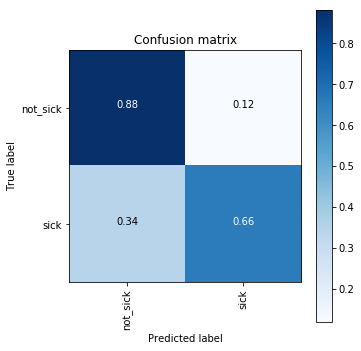

In [22]:
import os
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []
for label in class_labels:
    file_list = os.listdir(validation_data_dir + '/' + label)
    for file_name in file_list:
        img_path = validation_data_dir + '/' + label + '/' + file_name
        
        img = image.load_img(img_path, target_size=(224, 224))
        
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)* 1./255
        
        preds = model.predict(x)[0]
        
        y_true.append(label)
        y_pred.append(class_labels[np.argmax(preds)])
        
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, sorted(class_labels), normalize=True)